# Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime
import seaborn
from scipy import stats
#import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from empyrical import max_drawdown
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Data Input

In [4]:
hs300 = pd.read_excel("沪深300.xlsx", sheet_name = "沪深300")
hs300 = hs300.set_index("Date")
hs300

,open,close,high,low,volume,money
Date,,,,,,
2015-05-11,4582.09,4690.53,4690.95,4535.15,37383842000,583260000000
2015-05-12,4692.12,4747.42,4748.00,4660.02,37705389100,607123000000
2015-05-13,4746.71,4718.44,4758.00,4678.85,37073042400,590480000000
2015-05-14,4717.95,4700.78,4735.28,4670.17,33772515200,513220000000
2015-05-15,4690.76,4617.47,4690.76,4592.05,32843116600,506695000000
...,...,...,...,...,...,...
2021-04-28,5073.97,5119.24,5119.45,5059.26,12062031800,272183000000
2021-04-29,5128.28,5164.17,5170.59,5113.65,14009248000,294112000000
2021-04-30,5156.36,5123.49,5163.25,5094.93,16012162100,315075000000


### Put the information of sector index (dataframe) into a dictionary

In [5]:
work_area = ["沪深300能源","沪深300材料","沪深300工业","沪深300可选","沪深300消费","沪深300医药","沪深300金融","沪深300信息","沪深300电信","沪深300公用"]
dict_hs_work = {}
for work in work_area:
    dict_hs_work[work] = pd.read_excel("沪深300行业指数ENG.xlsx", sheet_name = work)
    dict_hs_work[work] = dict_hs_work[work].set_index('Date')
    dict_hs_work[work] = dict_hs_work[work].fillna(dict_hs_work[work].mean()) 
    dict_hs_work[work]["Tomr_Trend"] = dict_hs_work[work]["open"].shift(-1) > dict_hs_work[work]["open"]
    dict_hs_work[work].iloc[dict_hs_work[work].shape[0]-1,dict_hs_work[work].shape[1]-1] = np.nan
    dict_hs_work[work]["5_day_Trend"] = dict_hs_work[work]["open"].shift(-5) > dict_hs_work[work]["open"]
    dict_hs_work[work].iloc[-5:,dict_hs_work[work].shape[1]-1] = np.nan
li_hs_work = [dict_hs_work[work] for work in work_area]
df_hs_work = pd.concat(li_hs_work, axis = 1, keys = work_area)
df_hs_work.columns.names = ['Work','Daily info']
df_hs_work

Work          沪深300能源                                                 \
Daily info       open       high        low      close        volume   
Date                                                                   
2015-05-11  2627.2750  2682.8170  2602.7220  2681.4790  2.339789e+09   
2015-05-12  2687.1690  2704.6750  2653.0300  2690.4170  2.063345e+09   
2015-05-13  2685.0740  2685.0740  2626.3380  2639.9980  1.957072e+09   
2015-05-14  2625.7210  2678.1710  2593.1620  2671.2220  2.196221e+09   
2015-05-15  2652.8160  2652.8160  2572.2950  2576.7220  1.800280e+09   
...               ...        ...        ...        ...           ...   
2021-04-28  1393.3172  1418.1316  1390.5060  1418.1316  3.287671e+08   
2021-04-29  1419.0083  1432.4540  1405.5965  1428.4429  4.249378e+08   
2021-04-30  1428.1061  1428.2299  1394.6597  1401.0310  5.292590e+08   
2021-05-06  1417.2285  1454.0514  1417.2285  1448.0308  7.690417e+08   
2021-05-07  1451.6761  1480.4267  1449.8368  1464.5725  7.859628e+08   

Work                                                             ...  \
Daily info   mkt_cap_ard     pe_ttm   pb_lf  ps_ttm pcf_ocf_ttm  ...   
Date                                                             ...   
2015-05-11  4.526684e+06  27.559999  1.8073  0.8278      7.3858  ...   
2015-05-12  4.539455e+06  27.637699  1.8124  0.8301      7.4067  ...   
2015-05-13  4.441005e+06  27.038300  1.7730  0.8121      7.2460  ...   
2015-05-14  4.476160e+06  27.252399  1.7871  0.8185      7.3034  ...   
2015-05-15  4.322359e+06  26.316000  1.7257  0.7904      7.0524  ...   
...                  ...        ...     ...     ...         ...  ...   
2021-04-28  1.885643e+06  17.102699  0.7704  0.4260      3.2487  ...   
2021-04-29  1.896006e+06  12.897400  0.7676  0.4265      3.0059  ...   
2021-04-30  1.887065e+06   9.746900  0.7541  0.4188      2.8778  ...   
2021-05-06  1.942835e+06  10.035000  0.7764  0.4311      2.9629  ...   
2021-05-07  1.965526e+06  10.152200  0.7855  0.4362      2.9975  ...   

Work                 沪深300公用                                              \
Daily info tech_limitdownpct  yoyroe        RC10        RC20        RC50   
Date                                                                       
2015-05-11               0.0  0.6498   98.726113  116.816310  131.962057   
2015-05-12               0.0  0.6498  101.356633  119.612237  138.690557   
2015-05-13               0.0  0.6498  101.281929  111.064496  132.938089   
2015-05-14               0.0  0.6498  103.177381  115.203243  137.058671   
2015-05-15               0.0  0.6498   97.738064  108.033137  133.436777   
...                      ...     ...         ...         ...         ...   
2021-04-28               0.0  0.7477   97.766097   96.379504  107.768903   
2021-04-29               0.0  0.7477   99.609889   95.633879  106.409439   
2021-04-30               0.0  0.7477   98.182977   94.428388  105.000161   
2021-05-06               0.0  0.7477   98.143693   96.282317  103.078088   
2021-05-07               0.0  0.7477   98.204264   97.033638  103.811851   

Work                                                             
Daily info      STD6     STD12     STD26 Tomr_Trend 5_day_Trend  
Date                                                             
2015-05-11  5.652267  4.042167  3.282070        1.0         1.0  
2015-05-12  5.065666  4.280449  3.369374        1.0         0.0  
2015-05-13  4.554747  4.348502  3.442657        0.0         0.0  
2015-05-14  4.313981  4.322143  3.430204        1.0         1.0  
2015-05-15  3.273778  4.331665  3.481006        0.0         1.0  
...              ...       ...       ...        ...         ...  
2021-04-28  0.552951  0.717947  0.951613        1.0         NaN  
2021-04-29  0.566975  0.666984  0.866361        1.0         NaN  
2021-04-30  0.637102  0.692737  0.875965        0.0         NaN  
2021-05-06  0.618391  0.508201  0.868644        1.0         NaN  
2021-05-07  0.588848  0.472919  0.868514        NaN        

### Divide the origin dictionary into 3 dictionary

### 3 dictionary:
#### About the factor information for each sector (Explanatory Variables)
#### About the trend in next 5 days for each sector, upward or downward (Explained Variables)
#### About the trading information for each sector (like close price, open price)

In [6]:
dict_hs300work_factor = {}
dict_hs300work_trend5 = {}
dict_hs300work_trade_info = {}
for work in work_area:
    dict_hs300work_factor[work] = dict_hs_work[work].iloc[ : ,5:-2]
    dict_hs300work_trend5[work] = dict_hs_work[work].iloc[ : ,-1]
    dict_hs300work_trade_info[work] = dict_hs_work[work].iloc[ : ,0:5]

In [7]:
for work in work_area:
    df_extreme_factor = dict_hs300work_factor[work].quantile([0.025, 0.975])
    dict_hs300work_factor[work] = dict_hs300work_factor[work].clip(df_extreme_factor.iloc[0], df_extreme_factor.iloc[1],axis = 1)
    dict_hs300work_factor[work] = (dict_hs300work_factor[work]-dict_hs300work_factor[work].mean())/dict_hs300work_factor[work].std()

In [8]:
df_hs_work.loc["2015-05-11":"2020-05-07"].shape[0]

1217

In [9]:
train_prop = np.round(df_hs_work.loc["2015-05-11":"2020-05-07"].shape[0] / df_hs_work.shape[0],1)
train_prop

0.8

#### Using open price to get the return and put each sectors' return series into a dataframe 

In [246]:
dict_Return_Work = {}
for work in work_area:
    dict_Return_Work[work] = dict_hs300work_trade_info[work]["open"] / dict_hs300work_trade_info[work]["open"].iloc[0] - 1
dict_Return_Work ["Date"] = hs300.index
df_Return_Work = pd.DataFrame(dict_Return_Work).set_index("Date")
df_Return_Work

,沪深300能源,沪深300材料,沪深300工业,沪深300可选,沪深300消费,沪深300医药,沪深300金融,沪深300信息,沪深300电信,沪深300公用
Date,,,,,,,,,,
2015-05-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-05-12,0.022797,0.022364,0.027546,0.032440,0.016862,0.025743,0.015961,0.051926,0.018390,0.034523
2015-05-13,0.022000,0.031262,0.050882,0.037567,0.026440,0.029396,0.025639,0.052175,0.047006,0.080364
2015-05-14,-0.000591,0.036408,0.030696,0.052387,0.039078,0.035168,0.011313,0.070533,0.077278,0.047736
2015-05-15,0.009721,0.072994,0.022773,0.043349,0.031627,0.024762,0.000983,0.051158,0.045151,0.057958
...,...,...,...,...,...,...,...,...,...,...
2021-04-28,-0.469672,0.166976,-0.313729,0.309653,3.182798,1.126142,-0.073616,-0.002650,-0.397202,-0.289513
2021-04-29,-0.459894,0.183392,-0.304183,0.319689,3.297247,1.169061,-0.073152,0.000805,-0.394910,-0.287595
2021-04-30,-0.456431,0.172309,-0.305680,0.333941,3.313771,1.164273,-0.059106,0.005520,-0.400612,-0.284355


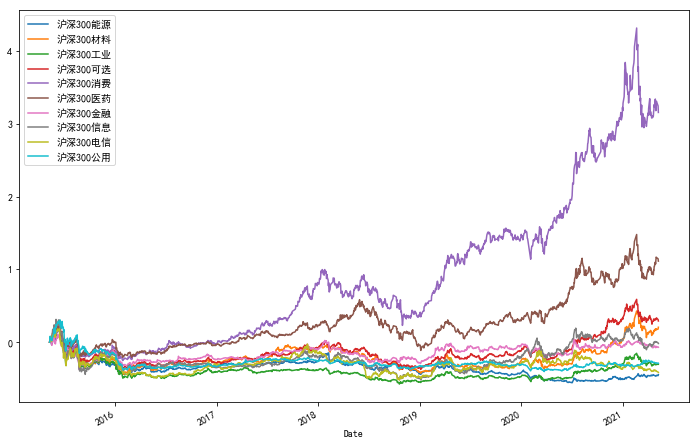

In [247]:
df_Return_Work.plot(figsize = (12,8))

#### For Cross Validation

In [11]:
dict_factor_train = {}
dict_trend5_train = {}
dict_factor_test = {}
dict_trend5_test ={}

for work in work_area:
    x_train, x_test, y_train, y_test = train_test_split(dict_hs300work_factor[work].iloc[:-5],dict_hs300work_trend5[work].dropna(),train_size = train_prop, random_state = 1)
    dict_factor_train[work] = x_train
    dict_factor_test[work] = x_test
    dict_trend5_train[work] = y_train
    dict_trend5_test[work] = y_test

### The following Function returns the accruacy measurement of random forest model with given unique minimum sample leaf but different minimum sample splits

In [12]:
def para_select_RF2(dict_hs300work_factor, dict_hs300work_trend5,dict_factor_train,dict_trend5_train, msl):
    dict_score_min_ss_work = {}
    min_sample_split_candi = range(6, 55, 6)
    for work in work_area:
        dict_accur = {}
        oob = []
        CV =[]
        accur_train = []
        accur_test = []
        auc_li = []
        for mss in min_sample_split_candi:
            RF = RandomForestClassifier(n_estimators = 100, max_features= int(np.ceil(math.sqrt(dict_factor_train[work].shape[1]))), max_depth = None, min_samples_split = mss, bootstrap=True, oob_score = True, min_samples_leaf = msl)
            oob.append(RF.oob_score)
            CV.append(cross_val_score(RF, dict_factor_train[work], dict_trend5_train[work]).mean())
            RF.fit(dict_hs300work_factor[work].loc["2015-05-11":"2020-05-07"], dict_hs300work_trend5[work].loc["2015-05-11":"2020-05-07"])
            trend5_train_pred = RF.predict(dict_hs300work_factor[work].loc["2015-05-11":"2020-05-07"])
            trend5_test_pred = RF.predict(dict_hs300work_factor[work].loc["2020-05-08":"2021-04-27"])
            accur_train.append(accuracy_score(dict_hs300work_trend5[work].loc["2015-05-11":"2020-05-07"],trend5_train_pred))
            accur_test.append(accuracy_score(dict_hs300work_trend5[work].loc["2020-05-08":"2021-04-27"],trend5_test_pred))
        
            trend5_preprob = RF.predict_proba(dict_hs300work_factor[work].loc["2020-05-08":"2021-04-27"])[:,1]
            fpr_Nb, tpr_Nb, _ = roc_curve(dict_hs300work_trend5[work].loc["2020-05-08":"2021-04-27"], trend5_preprob)
            accval = auc(fpr_Nb, tpr_Nb)
            auc_li.append(accval)
        dict_accur["OOB"] = oob
        dict_accur["Cross Validation Score"] = CV
        dict_accur["Accuracy Train"] = accur_train
        dict_accur["Accuracy Test"] = accur_test
        dict_accur["AUC"] = auc_li
        dict_accur["min sample split"] = min_sample_split_candi
        dict_score_min_ss_work[work] = pd.DataFrame(dict_accur).set_index("min sample split")
    return(dict_score_min_ss_work) 

### Through the iteration given different minimum sample leaf, then we can find the dictionary about the accruacy of random forest model with different minimum sample leaf

### This dictionary's element is also the dictionary about the accruacy of random forest model with different minimum sample split corresponding to the unique minimum sample leaf (keys of dictionary)

In [13]:
dict_para_select_msl_2 = {}
min_sample_leaf_candi = range(1,16,2)
for msl in min_sample_leaf_candi:
    dict_para_select_msl_2[msl] = para_select_RF2(dict_hs300work_factor, dict_hs300work_trend5,dict_factor_train,dict_trend5_train, msl)

#### Generate the 4 dictionaries about accuracy measurement correpoding to each sectors' random forest and  all possible parameters combinations

In [14]:
dict_CV_work2 = {}
dict_Accur_Train_work2 = {}
dict_Accur_Test_work2 = {}
dict_Accur_AUC_work2 = {}

for work in work_area:
    Li_work_accu2 = [dict_para_select_msl_2[msl][work] for msl in min_sample_leaf_candi]
    df_work_accu2 = pd.concat(Li_work_accu2, axis = 1, keys = min_sample_leaf_candi)
    df_work_accu2.columns.names = ["min sample leaf","Accuracy measure"]
    dict_CV_work2[work] = df_work_accu2.xs("Cross Validation Score", level = "Accuracy measure", axis = 1)
    dict_Accur_Train_work2[work] = df_work_accu2.xs("Accuracy Train", level = "Accuracy measure", axis = 1)
    dict_Accur_Test_work2[work] = df_work_accu2.xs("Accuracy Test", level = "Accuracy measure", axis = 1)
    dict_Accur_AUC_work2[work] = df_work_accu2.xs("AUC", level = "Accuracy measure", axis = 1)

In [15]:
dict_work_model_para2 = {}

## The following 10 heatmap shows all kinds of parameters combination and corresponding accuracy

# Notice that this is the random forest model, if you re-run this code, the results of best parameter selection may become different as what we analyze in report

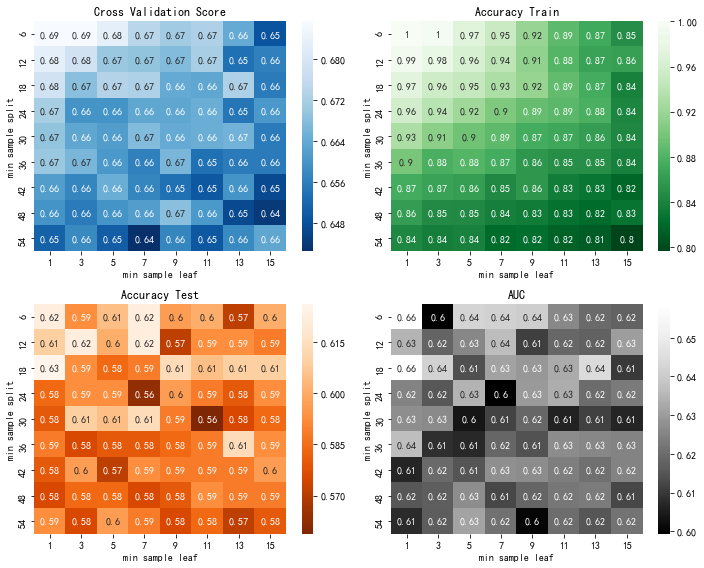

In [16]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300能源"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300能源"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300能源"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300能源"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [36]:
dict_work_model_para2["沪深300能源"] = [18,1]

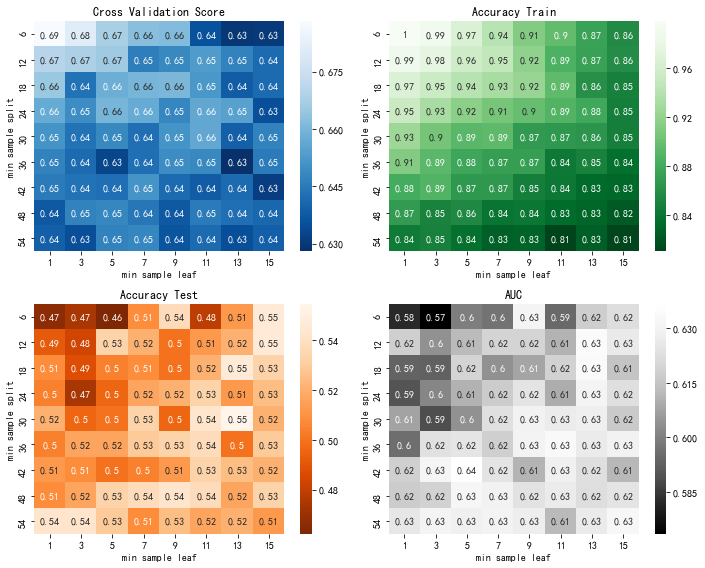

In [18]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300材料"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300材料"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300材料"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300材料"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [37]:
dict_work_model_para2["沪深300材料"] = [30,13]

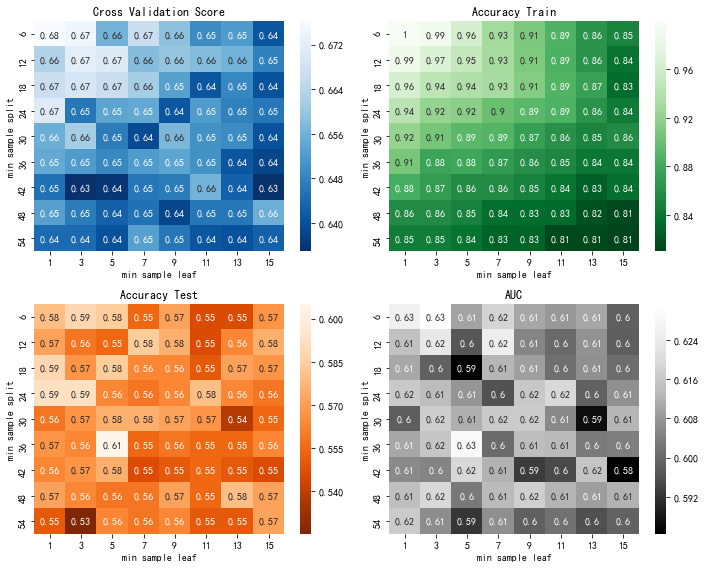

In [20]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300工业"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300工业"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300工业"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300工业"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [38]:
dict_work_model_para2["沪深300工业"] = [36,5]

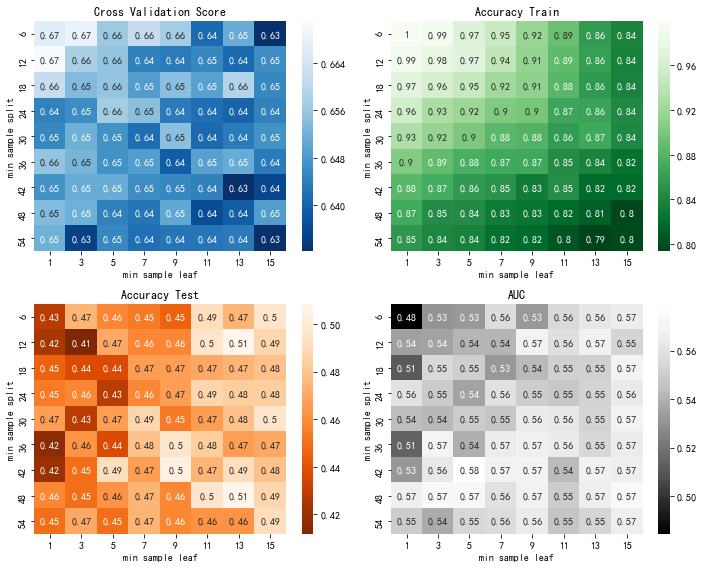

In [22]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300可选"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300可选"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300可选"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300可选"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [39]:
dict_work_model_para2["沪深300可选"] = [48,13]

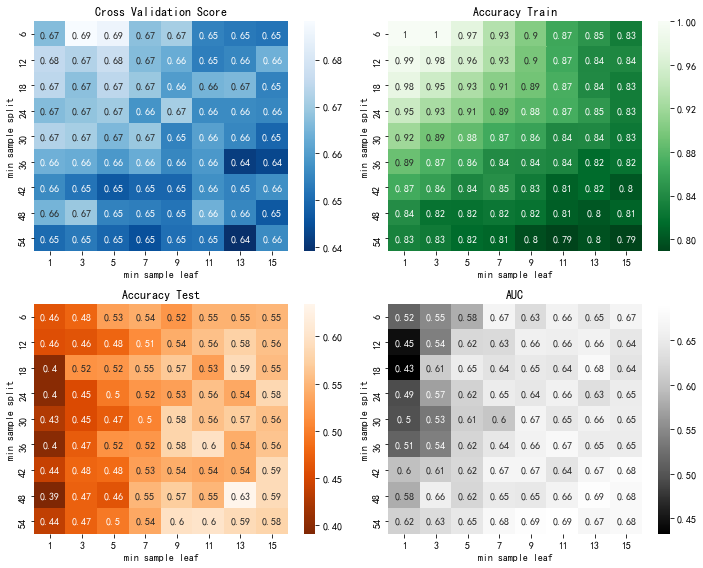

In [24]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300消费"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300消费"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300消费"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300消费"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [40]:
dict_work_model_para2["沪深300消费"] = [48,13]

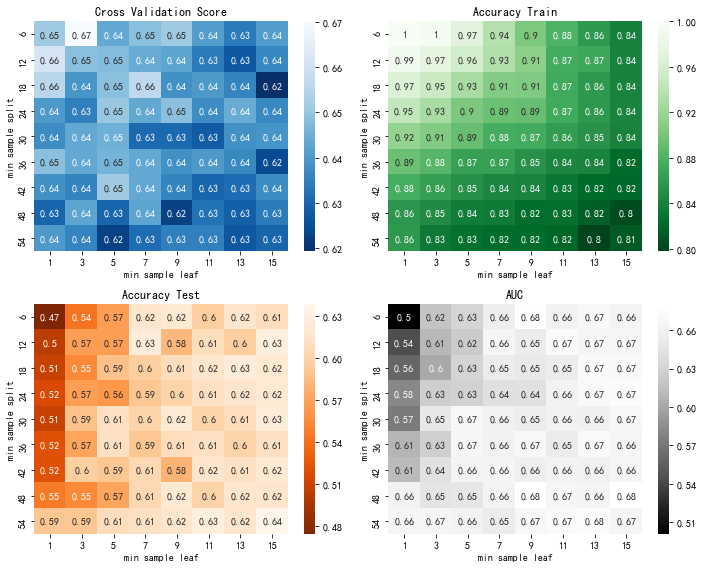

In [26]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300医药"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300医药"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300医药"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300医药"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [41]:
dict_work_model_para2["沪深300医药"] = [54,15]

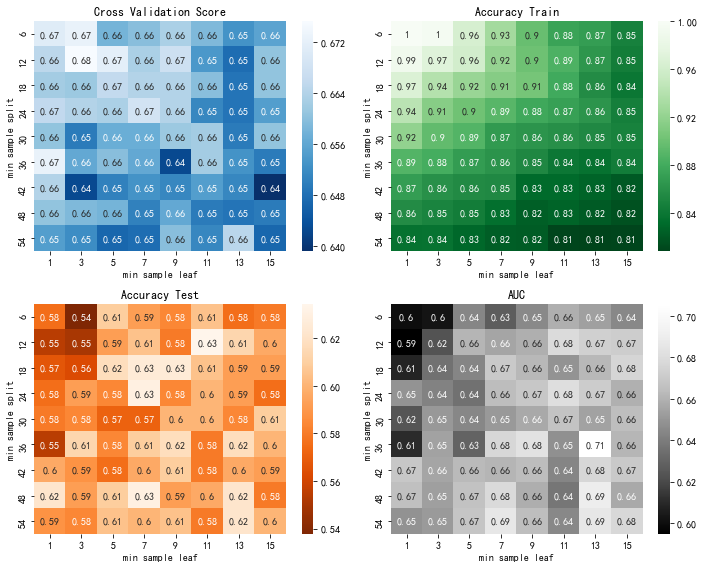

In [28]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300金融"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300金融"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300金融"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300金融"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [42]:
dict_work_model_para2["沪深300金融"] = [36,13]

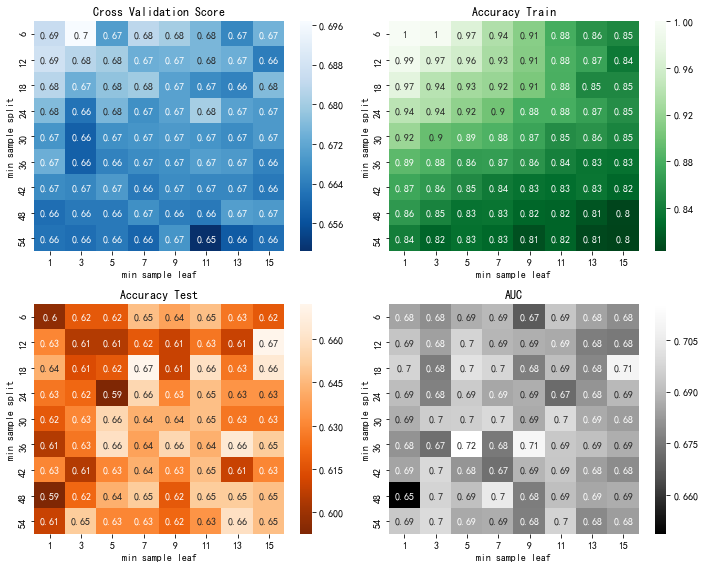

In [30]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300信息"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300信息"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300信息"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300信息"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [43]:
dict_work_model_para2["沪深300信息"] = [36,5]

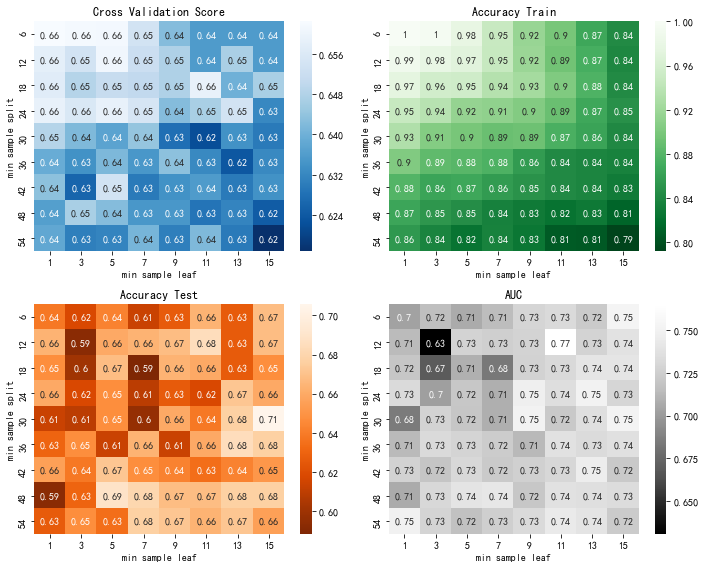

In [32]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300电信"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300电信"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300电信"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300电信"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [44]:
dict_work_model_para2["沪深300电信"] = [30,15]

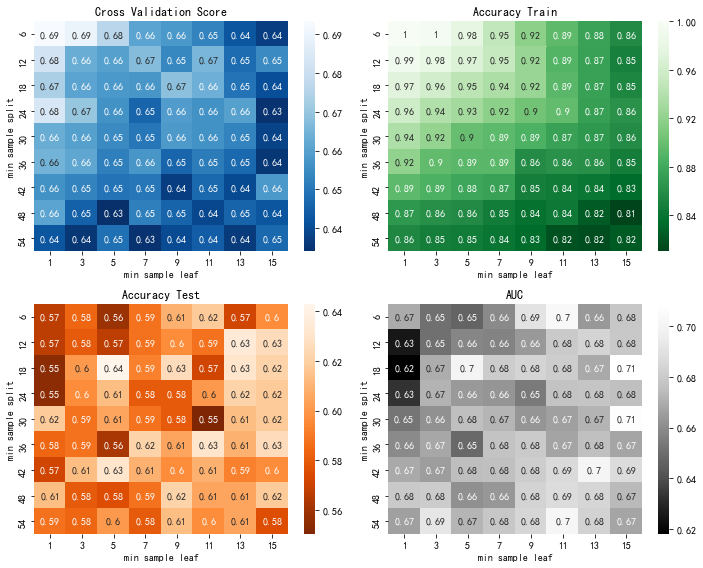

In [34]:
fig, axes = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
seaborn.heatmap(dict_CV_work2["沪深300公用"], annot = True, cmap = "Blues_r", ax = axes[0][0])
axes[0][0].set_title("Cross Validation Score")
seaborn.heatmap(dict_Accur_Train_work2["沪深300公用"], annot = True, cmap = "Greens_r", ax = axes[0][1])
axes[0][1].set_title("Accuracy Train")
seaborn.heatmap(dict_Accur_Test_work2["沪深300公用"], annot = True, cmap = "Oranges_r", ax = axes[1][0])
axes[1][0].set_title("Accuracy Test")
seaborn.heatmap(dict_Accur_AUC_work2["沪深300公用"], annot = True, cmap = "Greys_r", ax = axes[1][1])
axes[1][1].set_title("AUC")
plt.tight_layout()

In [45]:
dict_work_model_para2["沪深300公用"] = [18,5]

### Record the parameters selection for random forest model of each sectors into a dictionary

In [46]:
dict_work_model_para2

{'沪深300能源': [18, 1],
 '沪深300材料': [30, 13],
 '沪深300工业': [36, 5],
 '沪深300可选': [48, 13],
 '沪深300消费': [48, 13],
 '沪深300医药': [54, 15],
 '沪深300金融': [36, 13],
 '沪深300信息': [36, 5],
 '沪深300电信': [30, 15],
 '沪深300公用': [18, 5]}

### Fitting the random forest model for each sectors using the parameters we select

In [47]:
dict_RF_2 = {}
for work in work_area:
    RF = RandomForestClassifier(n_estimators = 100, max_features= int(np.ceil(math.sqrt(dict_factor_train[work].shape[1]))), max_depth = None, min_samples_split = dict_work_model_para2[work][0], bootstrap=True, oob_score = True, min_samples_leaf = dict_work_model_para2[work][1], random_state = 1)
    RF.fit(dict_hs300work_factor[work].loc["2015-05-11":"2020-05-07"], dict_hs300work_trend5[work].loc["2015-05-11":"2020-05-07"])
    dict_RF_2[work] = RF

## This is the back testing platform ONLY for Timing Strategy

### This is because we conmbine the strategy and back test trading

In [457]:
class Timing_Strategy:
    def __init__(self, name,df_hist_trade_info, df_hist_factor, df_hist_trend5, init_value, RF):
        self.name = name
        self.df_hist_trade_info = df_hist_trade_info
        self.df_hist_factor = df_hist_factor
        self.df_hist_trend5 = df_hist_trend5
        self.trading_days = df_hist_trade_info.shape[0]
        self.init_value = init_value
        self.Position = init_value * np.ones(self.trading_days)
        self.Return = np.zeros(self.trading_days)
        self.Based_Return = np.zeros(self.trading_days)
        self.share = np.zeros(self.trading_days) 
        self.hold = False
        self.RF = RF
        self.charge = 0
        self.long_times = 0
        self.short_times = 0
        self.Daily_Return = []
        self.Daily_Based_Return = []
        
    def Back_testing(self):
        for date_index in range(0,self.trading_days):
            if date_index != 0:
                self.Position[date_index] = self.Position[date_index-1] 
            if date_index % 5 == 0:
                trend5_forecast = (self.RF).predict(np.array(self.df_hist_factor.iloc[date_index]).reshape(1,41))[0]
                if self.hold == False:
                    if trend5_forecast == 1:
                        self.share[date_index] = self.Position[date_index] / self.df_hist_trade_info["open"].iloc[date_index]
                        self.charge += 0.0007 * self.Position[date_index]
                        self.Position[date_index] = (1-0.0007) * self.Position[date_index]
                        self.long_times += 1
                        self.hold = True
                else:
                    if trend5_forecast == 0:
                        self.share[date_index] = 0
                        self.short_times += 1
                        self.hold = False
                    else:
                        self.share[date_index] = self.share[date_index - 1]
            else:
                if date_index != 0:
                    self.share[date_index] = self.share[date_index - 1]
                if self.hold == True:
                    self.Position[date_index] = self.share[date_index] * self.df_hist_trade_info["open"].iloc[date_index]
        
        self.Return = self.Position / self.init_value - 1
        self.Based_Return = self.df_hist_trade_info["open"] / self.df_hist_trade_info["open"].iloc[0] - 1 
        
        for date_index in range(1,self.trading_days):
            self.Daily_Return.append(self.Position[date_index]/self.Position[date_index-1] - 1)
            self.Daily_Based_Return.append(self.df_hist_trade_info["open"].iloc[date_index]/self.df_hist_trade_info["open"].iloc[date_index-1] - 1)
            
    def Back_testing_plot(self):
        dict_compare_return = {}
        dict_compare_return["Random Forest Timing"] = self.Return
        dict_compare_return[self.name] = self.Based_Return
        df_compare_return = pd.DataFrame(dict_compare_return)
        df_compare_return.plot.area(title = self.name, figsize = (12,8), alpha = 0.4, stacked = False,ylabel = "Cumulative Return")
        
    def ex_ret(self):
        self.ex_ret = self.Return[self.trading_days-1] - self.Based_Return[self.trading_days-1]
        return np.round(self.ex_ret,3)
    
    def tim_maxdrawdown(self):
        return np.round(max_drawdown(np.array(self.Daily_Return)),3)
    
    def base_maxdrawdown(self):
        return np.round(max_drawdown(np.array(self.Daily_Based_Return)),3)
    
    
    def reduced_drawdown(self):
        return self.tim_maxdrawdown() - self.base_maxdrawdown()    
        
    def __del__(self):
        print("Timing Strategy for ", self.name," is Over")
    

### Do the back-testing for each sectors' Timing strategy

In [458]:
dict_strategy_object2 = {}
for work in work_area:
    dict_strategy_object2[work] = Timing_Strategy(work,dict_hs300work_trade_info[work].loc["2020-05-08":"2021-05-07"], dict_hs300work_factor[work].loc["2020-05-08":"2021-05-07"], dict_hs300work_trend5[work].loc["2020-05-08":"2021-05-07"], 1000000, dict_RF_2[work])
    dict_strategy_object2[work].Back_testing()

Timing Strategy for  沪深300能源  is Over
Timing Strategy for  沪深300材料  is Over
Timing Strategy for  沪深300工业  is Over
Timing Strategy for  沪深300可选  is Over
Timing Strategy for  沪深300消费  is Over
Timing Strategy for  沪深300医药  is Over
Timing Strategy for  沪深300金融  is Over
Timing Strategy for  沪深300信息  is Over
Timing Strategy for  沪深300电信  is Over
Timing Strategy for  沪深300公用  is Over


### The following 10 area line plot is the back-testing for Timing strategies corresponding to 10 sectors

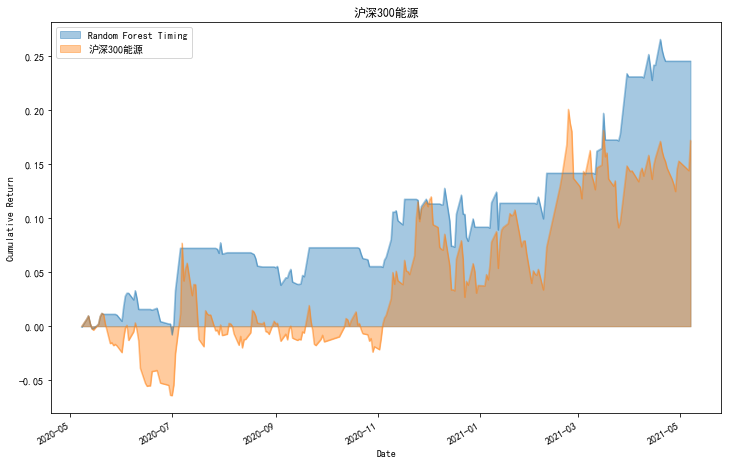

In [459]:
dict_strategy_object2["沪深300能源"].Back_testing_plot()

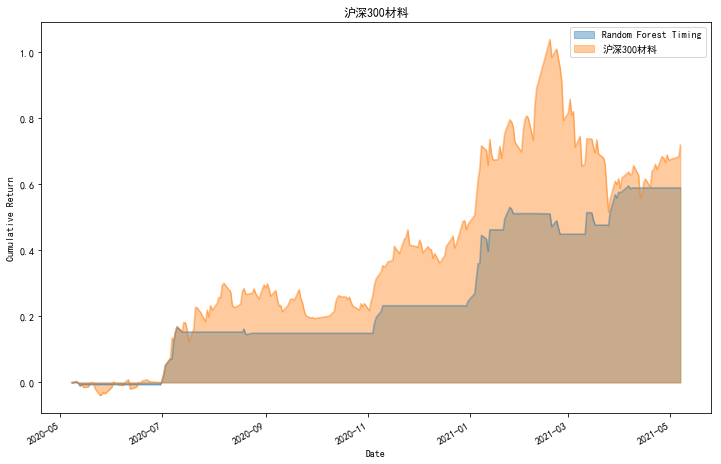

In [460]:
dict_strategy_object2["沪深300材料"].Back_testing_plot()

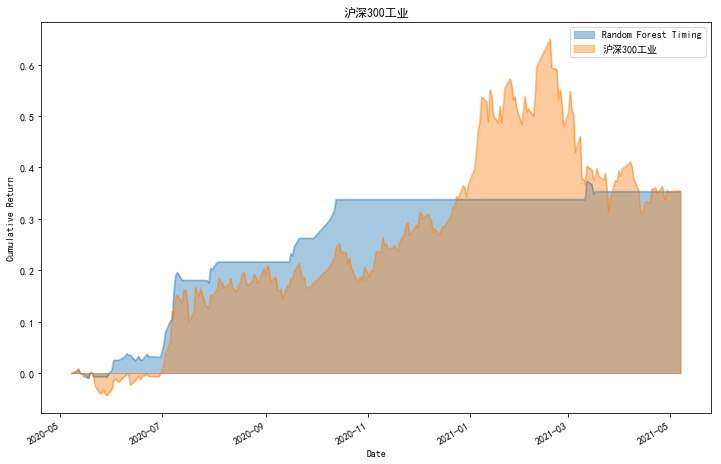

In [461]:
dict_strategy_object2["沪深300工业"].Back_testing_plot()

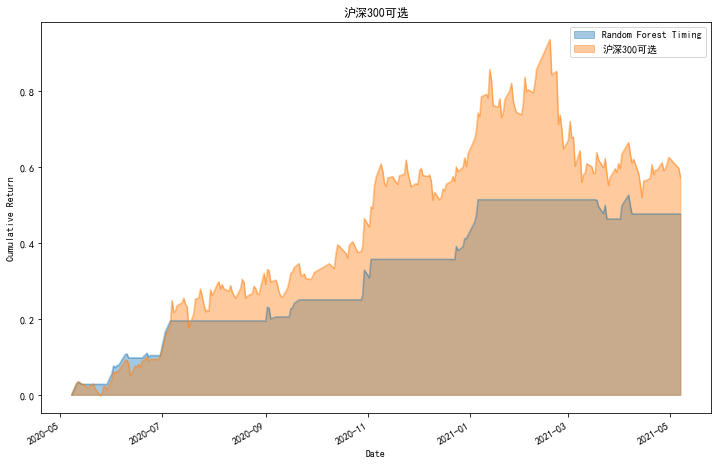

In [462]:
dict_strategy_object2["沪深300可选"].Back_testing_plot()

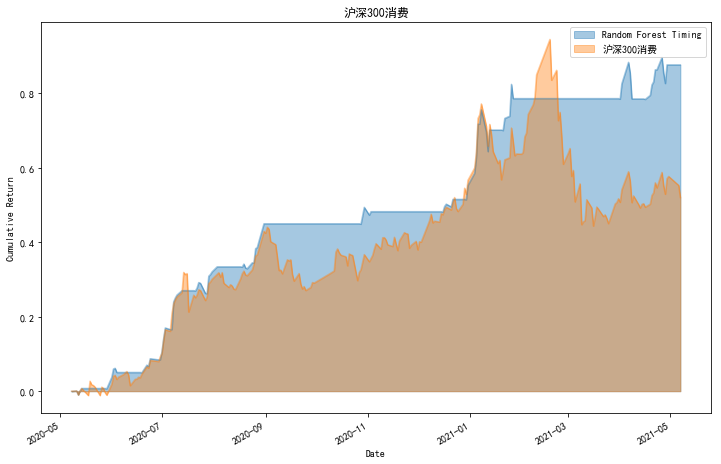

In [463]:
dict_strategy_object2["沪深300消费"].Back_testing_plot()

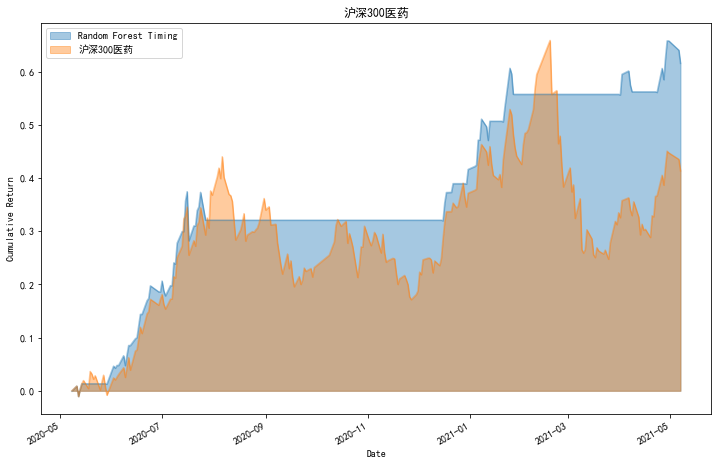

In [464]:
dict_strategy_object2["沪深300医药"].Back_testing_plot()

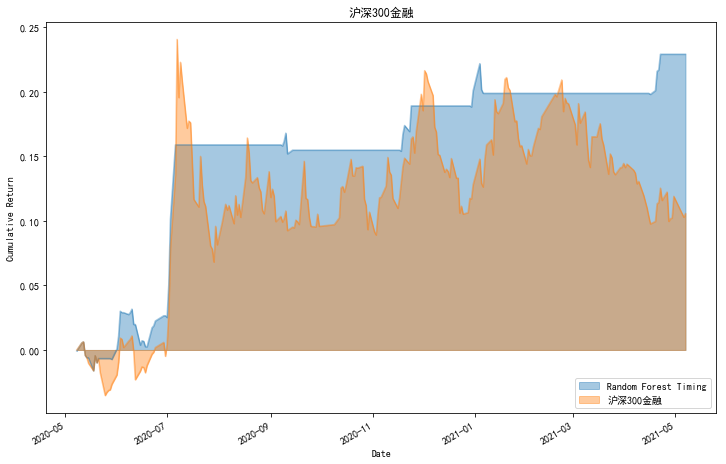

In [465]:
dict_strategy_object2["沪深300金融"].Back_testing_plot()

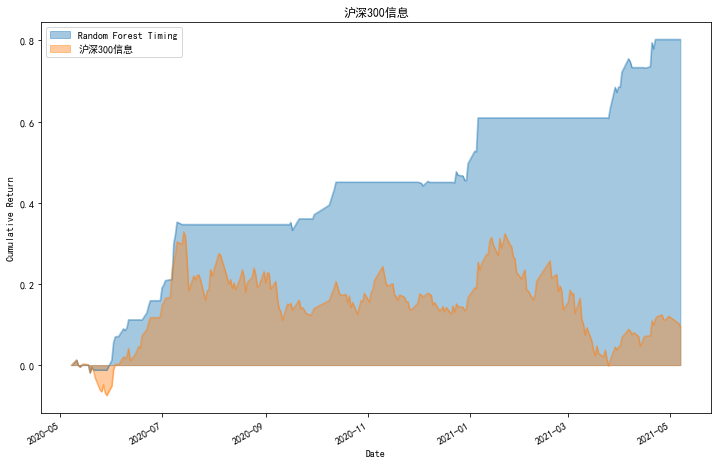

In [466]:
dict_strategy_object2["沪深300信息"].Back_testing_plot()

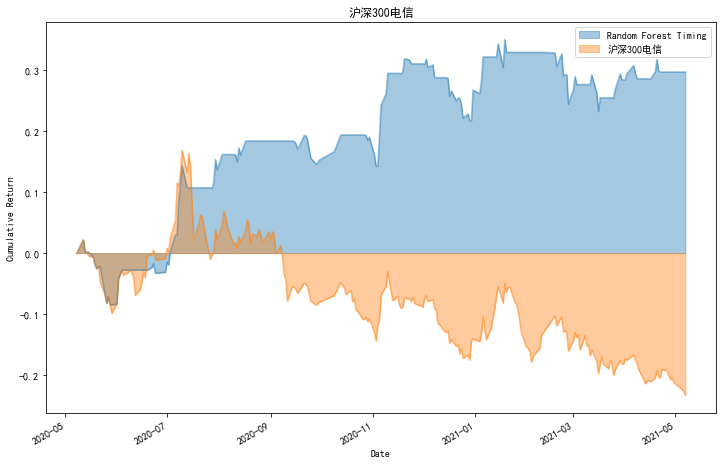

In [467]:
dict_strategy_object2["沪深300电信"].Back_testing_plot()

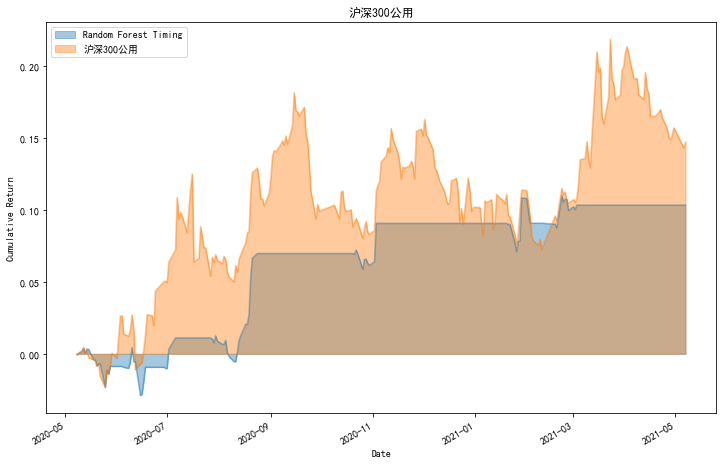

In [468]:
dict_strategy_object2["沪深300公用"].Back_testing_plot()

### This is to draw the table of back-tesing result

In [382]:
dict_back_test_info = {}
Long_times = []
Short_times = []
Charge = []
excess_return = []
tim_drawdown = []
base_drawdown = []
reduce_drawdown =[]
for work in work_area:
    Long_times.append(dict_strategy_object2[work].long_times)
    Short_times.append(dict_strategy_object2[work].short_times)
    Charge.append(np.round(dict_strategy_object2[work].charge,3))
    excess_return.append(dict_strategy_object2[work].ex_ret())
    tim_drawdown.append(dict_strategy_object2[work].tim_maxdrawdown())
    base_drawdown.append(dict_strategy_object2[work].base_maxdrawdown())
    reduce_drawdown.append(dict_strategy_object2[work].reduced_drawdown())
dict_back_test_info["Long Times"] = Long_times
dict_back_test_info["Short Times"] = Short_times
dict_back_test_info["Total Charge"] = Charge
dict_back_test_info["Excess Return of Timing Strategy"] = excess_return
dict_back_test_info["Max Drawdown of Timing Strategy"] = tim_drawdown
dict_back_test_info["Max Drawdown of Base Portfolio"]d = base_drawdown
dict_back_test_info["Reduced Drawdown"] = reduce_drawdown
dict_back_test_info["Industry"] = work_area
df_back_test_info = pd.DataFrame(dict_back_test_info).set_index("Industry")
df_back_test_info

,Long Times,Short Times,Total Charge,Excess Return of Timing Strategy,Max Drawdown of Timing Strategy,Max Drawdown of Base Portfolio,Reduced Drawdown
Industry,,,,,,,
沪深300能源,15,15,11432.163,0.073,-0.048,-0.094,0.046
沪深300材料,9,9,8000.052,-0.130,-0.054,-0.257,0.203
沪深300工业,6,6,4892.750,-0.000,-0.019,-0.207,0.188
沪深300可选,9,9,7776.433,-0.097,-0.034,-0.215,0.181
沪深300消费,11,11,10767.140,0.356,-0.064,-0.258,0.194
沪深300医药,7,6,6544.471,0.202,-0.067,-0.248,0.181
沪深300金融,6,6,4686.141,0.123,-0.028,-0.139,0.111
沪深300信息,9,9,8434.734,0.709,-0.031,-0.249,0.218
沪深300电信,14,14,11880.552,0.529,-0.104,-0.343,0.239


In [442]:
df_back_test_info["Excess Return of Timing Strategy"].mean()

0.17209999999999998

In [443]:
df_back_test_info["Reduced Drawdown"].mean()

0.162

In [455]:
dict_position ={}
for work in work_area:
    dict_position[work] = dict_strategy_object2[work].Position
dict_position["Date"] = hs300.loc["2020-05-08":"2021-05-07"].index
df_position = pd.DataFrame(dict_position).set_index("Date")
df_position.iloc[-1]

沪深300能源    1.245376e+06
沪深300材料    1.589168e+06
沪深300工业    1.353069e+06
沪深300可选    1.476327e+06
沪深300消费    1.876480e+06
沪深300医药    1.615419e+06
沪深300金融    1.228961e+06
沪深300信息    1.802402e+06
沪深300电信    1.296200e+06
沪深300公用    1.103303e+06
Name: 2021-05-07 00:00:00, dtype: float64

In [456]:
df_position.iloc[-1].mean()

1458670.4500046147

## This is the back-testing platform ONLY for sector rotation strategy

In [469]:
class Sector_Rotation:
    def __init__(self, df_hs300,dict_hs300work_trade_info, dict_hs300work_factor, dict_hs300work_trend5, init_value, dict_RF, work_area):
        self.df_hs300 = df_hs300
        self.dict_hs300work_trade_info = dict_hs300work_trade_info
        self.dict_hs300work_factor = dict_hs300work_factor
        self.dict_hs300work_trend5 = dict_hs300work_trend5
        self.trading_days = dict_hs300work_trade_info[work_area[0]].shape[0]
        self.Position = init_value * np.ones(self.trading_days)
        self.Return = np.zeros(self.trading_days)
        self.Based_Return = self.df_hs300["open"] / self.df_hs300["open"].iloc[0] - 1
        self.share = list(np.zeros(self.trading_days).reshape(self.trading_days,1)) 
        self.hold = list(np.zeros(self.trading_days).reshape(self.trading_days,1)) 
        self.whether_hold = False
        self.dict_RF = dict_RF
        self.charge = 0
        self.long_times = 0
        self.short_times = 0
        self.Daily_Return = []
        self.Daily_Based_Return = []
        self.work_area = work_area
        self.init_value = init_value
        self.probability_record = {"1st Work":[],"1st Work prob":[], "2nd Work":[],"2nd Work prob":[], "mean prob":[], "Date":[]}
        
    def Back_testing(self):
        for date_index in range(0,self.trading_days):
            if date_index != 0:
                self.Position[date_index] = self.Position[date_index-1] 
            if date_index % 5 == 0:
                dict_Prob_up = {}
                li_Prob_up = []
                for work in self.work_area:
                    dict_Prob_up[work] = self.dict_RF[work].predict_proba(np.array(dict_hs300work_factor[work].iloc[date_index]).reshape(1,41))[0,1]    
                    li_Prob_up.append(dict_Prob_up[work])
                Prob_up_sort = sorted(dict_Prob_up.items(), key = lambda acd:acd[1], reverse=True)
                self.probability_record["mean prob"].append(np.array(li_Prob_up).mean())
                work1 = Prob_up_sort[0][0]
                work2 = Prob_up_sort[1][0]
                work1_prob = Prob_up_sort[0][1]
                work2_prob = Prob_up_sort[1][1]
                self.probability_record["1st Work"].append(work1)
                self.probability_record["1st Work prob"].append(work1_prob)
                self.probability_record["2nd Work"].append(work2)
                self.probability_record["2nd Work prob"].append(work2_prob)
                self.probability_record["Date"].append(self.df_hs300.index[date_index])
                
                if work1_prob >= 0.5 and work2_prob < 0.5:
                    if work1 not in self.hold[date_index-1] or date_index == 0:
                        self.hold[date_index] = [work1]
                        self.share[date_index] = [self.Position[date_index]/dict_hs300work_trade_info[work1]["open"].iloc[date_index]]
                        self.charge += 0.0007 * self.Position[date_index]
                        self.Position[date_index] = (1-0.0007) * self.Position[date_index]
                        self.long_times += 1
                        if date_index != 0:
                            if self.share[date_index-1] != 0 and len(self.share[date_index-1]) == 1:
                                self.short_times += 1
                            elif len(self.share[date_index-1]) == 2:
                                self.short_times += 2
                        self.whether_hold = True
                    else:
                        self.hold[date_index] = [work1]
                        if len(self.hold[date_index]) == 2:
                            share_work1 = self.Position[date_index]/dict_hs300work_trade_info[work1]["open"].iloc[date_index]
                            self.share[date_index] = [share_work1]
                            if self.hold[date_index-1][0] == work1:
                                share_work1_yest = self.share[date_index-1][0] 
                            else:
                                share_work1_yest = self.share[date_index-1][1]
                            pos_other_part = self.Position[date_index] - share_work1_yest * dict_hs300work_trade_info[work1]["open"].iloc[date_index]
                            self.charge += 0.0007 * pos_other_part
                            self.Position[date_index] -= 0.0007 * pos_other_part
                            self.long_times += 1
                            self.short_times += 1   
                            self.whether_hold = True
                        else:
                            self.share[date_index] = self.share[date_index-1]
                            
                elif work2_prob >= 0.5:
                    if date_index == 0 or (work1 not in self.hold[date_index-1] and work2 not in self.hold[date_index-1]):
                        self.hold[date_index] = [work1, work2]
                        Total_prob = work1_prob + work2_prob
                        self.share[date_index] = [work1_prob/Total_prob * self.Position[date_index]/dict_hs300work_trade_info[work1]["open"].iloc[date_index] ,work2_prob/Total_prob * self.Position[date_index]/dict_hs300work_trade_info[work2]["open"].iloc[date_index]]
                        self.charge += 0.0007 * self.Position[date_index]
                        self.Position[date_index] = (1-0.0007) * self.Position[date_index]
                        self.long_times += 2
                        if date_index != 0:
                            if self.share[date_index-1] != 0 and len(self.share[date_index-1]) == 1:
                                self.short_times += 1
                            elif len(self.share[date_index-1]) == 2:
                                self.short_times += 2   
                        self.whether_hold = True
                    
                    elif work1 not in self.hold[date_index-1] and work2 in self.hold[date_index-1]:
                        self.hold[date_index] = [work1, work2]
                        Total_prob = work1_prob + work2_prob
                        if len(self.hold[date_index-1]) == 2:
                            if self.hold[date_index-1][0] == work2:
                                share_work2 = self.share[date_index-1][0] 
                            else:
                                share_work2 = self.share[date_index-1][1]
                            pos_work1 = self.Position[date_index] - share_work2 * dict_hs300work_trade_info[work2]["open"].iloc[date_index]
                            self.share[date_index] = [pos_work1/dict_hs300work_trade_info[work1]["open"].iloc[date_index],share_work2]  
                            self.charge += 0.0007 * pos_work1
                            self.Position[date_index] -= 0.0007 * pos_work1 
                        else:
                            self.share[date_index] = [work1_prob/Total_prob * self.Position[date_index]/dict_hs300work_trade_info[work1]["open"].iloc[date_index] ,work2_prob/Total_prob * self.Position[date_index]/dict_hs300work_trade_info[work2]["open"].iloc[date_index]]
                            self.charge += 0.0007 * work1_prob/Total_prob * self.Position[date_index]
                            self.Position[date_index] -= 0.0007 * work1_prob/Total_prob * self.Position[date_index]
                        self.long_times += 1
                        self.short_times += 1
                        self.whether_hold = True  
                        
                    elif work1 in self.hold[date_index-1] and work2 not in self.hold[date_index-1]:
                        if len(self.hold[date_index-1]) == 2:
                            self.hold[date_index] = [work1, work2]
                            Total_prob = work1_prob + work2_prob
                            if self.hold[date_index-1][0] == work1:
                                share_work1 = self.share[date_index-1][0]
                            else:
                                share_work1 = self.share[date_index-1][1]
                            pos_work2 = self.Position[date_index] - share_work1 * dict_hs300work_trade_info[work1]["open"].iloc[date_index]
                            self.share[date_index] = [share_work1,pos_work2/dict_hs300work_trade_info[work2]["open"].iloc[date_index]]  
                            self.charge += 0.0007 * pos_work2
                            self.Position[date_index] -= 0.0007 * pos_work2
                            self.long_times += 1
                            self.short_times += 1
                            self.whether_hold = True
                        else:
                            self.hold[date_index] = self.hold[date_index-1]
                            self.share[date_index] = self.share[date_index-1]
                    
                    else:
                        self.hold[date_index] = self.hold[date_index-1]
                        self.share[date_index] = self.share[date_index-1]
                        
                else:
                    if date_index != 0:
                        if self.share[date_index-1] != 0 and len(self.share[date_index-1]) == 1:
                            self.short_times += 1
                        elif len(self.share[date_index-1]) == 2 :
                            self.short_times += 2
                    self.whether_hold = False
            else:
                self.hold[date_index] = self.hold[date_index-1]
                self.share[date_index] = self.share[date_index-1]
                if self.whether_hold == True:
                    if len(self.hold[date_index]) == 1:
                        work1 = self.hold[date_index][0]
                        share_work1 = self.share[date_index][0]
                        self.Position[date_index] = share_work1 * dict_hs300work_trade_info[work1]["open"].iloc[date_index]
                    elif len(self.hold[date_index]) == 2:
                        work1 = self.hold[date_index][0]
                        share_work1 = self.share[date_index][0]
                        work2 = self.hold[date_index][1]
                        share_work2 = self.share[date_index][1]
                        self.Position[date_index] = share_work1 * dict_hs300work_trade_info[work1]["open"].iloc[date_index] + share_work2 * dict_hs300work_trade_info[work2]["open"].iloc[date_index]
        self.Return = self.Position / self.init_value - 1
        for date_index in range(1,self.trading_days):
            self.Daily_Return.append(self.Position[date_index]/self.Position[date_index-1] - 1)
            self.Daily_Based_Return.append(self.df_hs300["open"].iloc[date_index]/self.df_hs300["open"].iloc[date_index-1] - 1)
                        
    
    def Back_testing_plot(self):
        dict_compare_return = {}
        dict_compare_return["Sector Rotation"] = self.Return
        dict_compare_return["沪深300"] = self.Based_Return
        df_compare_return = pd.DataFrame(dict_compare_return)
        df_compare_return.plot.area(title ="Sector Rotation" , figsize = (12,8), alpha = 0.4, stacked = False, ylabel = "Cumulative Return")
    
    def __del__(self):
        print("Industry rotation for is Over")
   
    def ex_ret(self):
        self.ex_ret = self.Return[self.trading_days-1] - self.Based_Return[self.trading_days-1]
        return np.round(self.ex_ret,3)
    
    def tim_maxdrawdown(self):
        return np.round(max_drawdown(np.array(self.Daily_Return)),3)
        
    def SharpeRatio(self):
        return self.Annualized_Return()/self.Annualized_Volatility()
        
#-------------
#def victory_ratio(self):
#        return (self.Daily_Return>0).mean()# pricesell是array或list
#--------------
    
    def Annualized_Return(self):
        return (1+(self.Position[self.trading_days-1]-self.Position[0])/self.Position[0])**(365/365)-1
    
    def Annualized_Volatility(self):
        DailyReturns=np.array(self.Daily_Return)
        return np.std(DailyReturns)*np.sqrt(self.trading_days)# self.trading_days为一年期的交易日
    
    def beta(self):
        cov_mat = np.cov(np.array(self.Daily_Based_Return),np.array(self.Daily_Return))/np.var(np.array(self.Daily_Based_Return))
        return cov_mat[0,1]
    
    def alpha(self):
        Rf=0
        Rm=np.array(self.Daily_Based_Return).mean()
        R=np.array(self.Daily_Return).mean()
        return ((R-Rf)-self.beta()*(Rm-Rf))
    
    def Trading_detail(self):
        dict_detail_info = {}
        dict_detail_info["Cumulaitve Return"] = self.Return
        work1_record = []
        work1_share = []
        work1_price = []
        work2_record = []
        work2_share = []
        work2_price = []
        for date_index in range(0,self.trading_days):
            if len(self.hold[date_index]) == 2:
                work1_record.append(self.hold[date_index][0])
                work1_share.append(self.share[date_index][0])
                work1_price.append(self.dict_hs300work_trade_info[self.hold[date_index][0]]["open"].iloc[date_index])
                work2_record.append(self.hold[date_index][1])
                work2_share.append(self.share[date_index][1])
                work2_price.append(self.dict_hs300work_trade_info[self.hold[date_index][1]]["open"].iloc[date_index])
            elif len(self.hold[date_index]) == 1 and self.hold[date_index] != 0:
                work1_record.append(self.hold[date_index][0])
                work1_share.append(self.share[date_index][0])
                work1_price.append(self.dict_hs300work_trade_info[self.hold[date_index][0]]["open"].iloc[date_index])
                work2_record.append(0)
                work2_share.append(0)
                work2_price.append(0)
            else:
                work1_record.append(0)
                work1_share.append(0)
                work1_price.append(0)
                work2_record.append(0)
                work2_share.append(0)
                work2_price.append(0)
        dict_detail_info["work1 Record"] = work1_record
        dict_detail_info["work1 Share Record"] = work1_share
        dict_detail_info["work1 Price"] = work1_price
        dict_detail_info["work2 Record"] = work2_record
        dict_detail_info["work2 Share Record"] = work2_share
        dict_detail_info["work2 Price"] = work2_price       
        
        df_detail_info = pd.DataFrame(dict_detail_info)
        df_detail_info.index = self.df_hs300.index
        return(df_detail_info)
    
    def Probability_Record(self):
        df_Probability_Record = pd.DataFrame(self.probability_record).set_index("Date")
        return(df_Probability_Record)

In [364]:
dict_hs300work_trade_info_Test = {}
dict_hs300work_factor_Test = {}
dict_hs300work_trend5_Test = {}
for work in work_area:
    dict_hs300work_trade_info_Test[work] = dict_hs300work_trade_info[work].loc["2020-05-08":"2021-05-07"]
    dict_hs300work_factor_Test[work] = dict_hs300work_factor[work].loc["2020-05-08":"2021-05-07"]
    dict_hs300work_trend5_Test[work] = dict_hs300work_trend5[work].loc["2020-05-08":"2021-05-07"]

### Generate the sector strategy object

In [470]:
strategy_ob_SR = Sector_Rotation(hs300.loc["2020-05-08":"2021-05-07"],dict_hs300work_trade_info_Test, dict_hs300work_factor_Test, dict_hs300work_trend5_Test, 1000000,dict_RF_2,work_area)

Industry rotation for is Over


### Do the back testing of sector strategy

In [471]:
strategy_ob_SR.Back_testing()

### Plot the back testing result of sector strategy

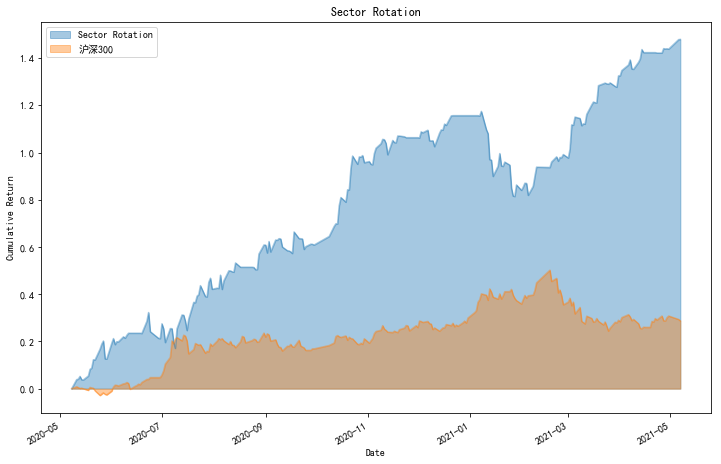

In [472]:
strategy_ob_SR.Back_testing_plot()

### Make a table about the result of back testing of sector rotation strategy

In [473]:
SR_back_test_info = {}
SR_back_test_info["Long Times"] = strategy_ob_SR.long_times
SR_back_test_info["Short Times"] = strategy_ob_SR.short_times
SR_back_test_info["Total Charge"] = np.round(strategy_ob_SR.charge,3)
SR_back_test_info["Excess Return"] = strategy_ob_SR.ex_ret()
SR_back_test_info["Max Drawdown"] = strategy_ob_SR.tim_maxdrawdown()
SR_back_test_info["Annualized Return"] = strategy_ob_SR.Annualized_Return()
SR_back_test_info["Annualized Volatility"] = strategy_ob_SR.Annualized_Volatility()
SR_back_test_info["Sharpe Ratio"] =strategy_ob_SR.SharpeRatio()
SR_back_test_info["Beta"] =strategy_ob_SR.beta()
SR_back_test_info["Alpha"] =strategy_ob_SR.alpha()

In [331]:
df_SR_back_test_info = pd.DataFrame(pd.Series(SR_back_test_info))
df_SR_back_test_info

,0
Long Times,60.000000
Short Times,60.000000
Total Charge,39734.754000
Excess Return,1.193000
Max Drawdown,-0.166000
Annualized Return,1.481165
Annualized Volatility,0.312811
Sharpe Ratio,4.735020
Beta,0.019424
Alpha,0.003941


### Detail about upward probability estimation

In [332]:
df_Probability_Record = strategy_ob_SR.Probability_Record()
df_Probability_Record

,1st Work,1st Work prob,2nd Work,2nd Work prob,mean prob
Date,,,,,
2020-05-08,沪深300医药,0.762602,沪深300信息,0.696060,0.601654
2020-05-15,沪深300能源,0.722991,沪深300信息,0.693938,0.594328
2020-05-22,沪深300材料,0.770850,沪深300医药,0.752113,0.549388
2020-05-29,沪深300公用,0.721649,沪深300医药,0.711689,0.635640
2020-06-05,沪深300公用,0.669896,沪深300消费,0.646313,0.518709
2020-06-12,沪深300可选,0.388694,沪深300消费,0.385796,0.282147
2020-06-19,沪深300消费,0.534070,沪深300材料,0.436267,0.354337
2020-06-30,沪深300金融,0.620690,沪深300消费,0.583970,0.432388
2020-07-07,沪深300能源,0.670009,沪深300金融,0.536360,0.480338


### Trading Detail

In [413]:
df_Position_detail = strategy_ob_SR.Trading_detail().loc[df_Probability_Record.index]
df_Position_detail["work1 weight"] = df_Position_detail["work1 Share Record"]*df_Position_detail["work1 Price"]/(df_Position_detail["work1 Share Record"]*df_Position_detail["work1 Price"] + df_Position_detail["work2 Share Record"]*df_Position_detail["work2 Price"])
df_Position_detail["work2 weight"] = df_Position_detail["work2 Share Record"]*df_Position_detail["work2 Price"]/(df_Position_detail["work1 Share Record"]*df_Position_detail["work1 Price"] + df_Position_detail["work2 Share Record"]*df_Position_detail["work2 Price"])
df_Position_detail

,Cumulaitve Return,work1 Record,work1 Share Record,work1 Price,work2 Record,work2 Share Record,work2 Price,work1 weight,work2 weight
Date,,,,,,,,,
2020-05-08,-0.000700,沪深300医药,63.751255,12264.2844,沪深300信息,164.142446,2608.1384,0.646184,0.353816
2020-05-15,0.036985,沪深300能源,209.109209,1234.2692,沪深300信息,164.142446,2616.5196,0.375371,0.624629
2020-05-22,0.121595,沪深300材料,179.874570,1972.5466,沪深300医药,61.269211,12611.0392,0.314694,0.685306
2020-05-29,0.125559,沪深300公用,181.266856,1636.4717,沪深300医药,61.269211,12164.2621,0.284700,0.715300
2020-06-05,0.198363,沪深300公用,181.266856,1658.0246,沪深300消费,62.709181,23800.3118,0.167617,0.832383
2020-06-12,0.234746,0,0.000000,0.0000,0,0.000000,0.0000,NaN,NaN
2020-06-19,0.233881,沪深300消费,142.369955,23996.5632,0,0.000000,0.0000,1.000000,0.000000
2020-06-30,0.212430,沪深300金融,98.791288,6020.8121,沪深300消费,73.181617,25058.1827,0.244916,0.755084
2020-07-07,0.254089,沪深300能源,267.250901,1333.9519,沪深300金融,98.791288,7504.9570,0.324704,0.675296


In [414]:
dict_Return_Work_20_21 = {}
for work in work_area:
    dict_Return_Work_20_21[work] = dict_hs300work_trade_info[work]["open"].loc["2020-05-08":"2021-05-08"] / dict_hs300work_trade_info[work]["open"].loc["2020-05-08"]- 1
dict_Return_Work_20_21["Date"] = hs300.loc["2020-05-08":"2021-05-08"].index
df_Return_Work_20_21 = pd.DataFrame(dict_Return_Work_20_21).set_index("Date")

### cumulative return of CSI 300 sector index

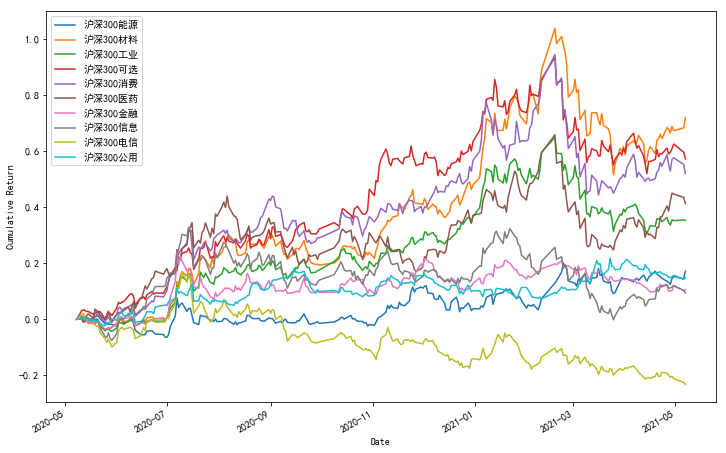

In [474]:
df_Return_Work_20_21.plot(figsize = (12,8), ylabel = "Cumulative Return")

In [420]:
dict_Daily_Return_Work_20_21 = {}
for work in work_area:
    dict_Daily_Return_Work_20_21[work] = dict_hs300work_trade_info[work]["open"].loc[df_Probability_Record.index].pct_change()
dict_Daily_Return_Work_20_21["Date"] = df_Probability_Record.index
df_Daily_Return_Work_20_21 = pd.DataFrame(dict_Daily_Return_Work_20_21).set_index("Date")

### weekly return of CSI sector index

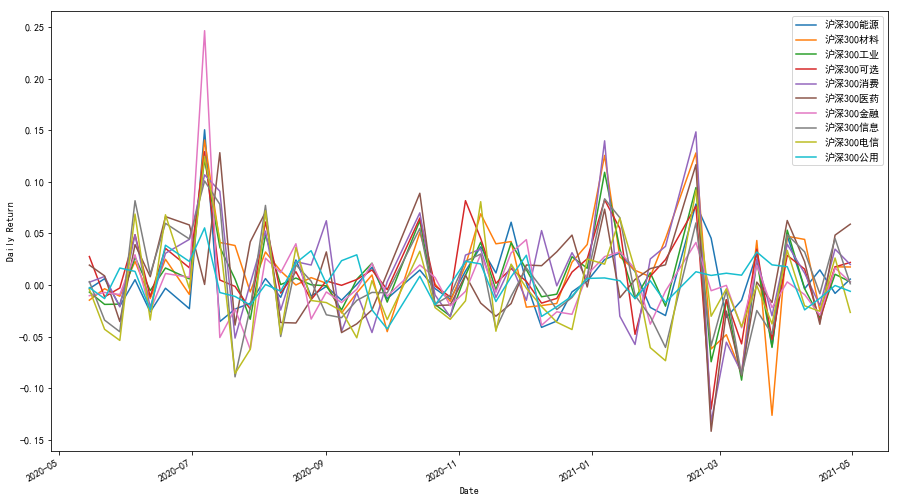

In [475]:
df_Daily_Return_Work_20_21.plot(figsize = (15,9), ylabel="Daily Return")

## This is the accuracy of timing strategy for each sector

In [451]:
dict_accuracy_RF = {}
for work in work_area:
    trend5_test_pred_ = dict_RF_2[work].predict(dict_hs300work_factor[work].loc[df_Probability_Record.index])
    dict_accuracy_RF[work] = accuracy_score(dict_hs300work_trend5[work].loc[df_Probability_Record.index].dropna(),trend5_test_pred_[:-1])
df_accracy_RF = pd.DataFrame(pd.Series(dict_accuracy_RF))
df_accracy_RF

,0
沪深300能源,0.645833
沪深300材料,0.562500
沪深300工业,0.562500
沪深300可选,0.520833
沪深300消费,0.708333
沪深300医药,0.645833
沪深300金融,0.604167
沪深300信息,0.729167
沪深300电信,0.687500
沪深300公用,0.541667


In [452]:
df_accracy_RF.mean()

0    0.620833
dtype: float64

### Plot the estimation of upward probability in each trading date

In [336]:
marker_work = ["o", "D", "x", "^", ">", "+", "_", "s", "d", "3"]
dict_work_mark = dict(zip(work_area,marker_work))

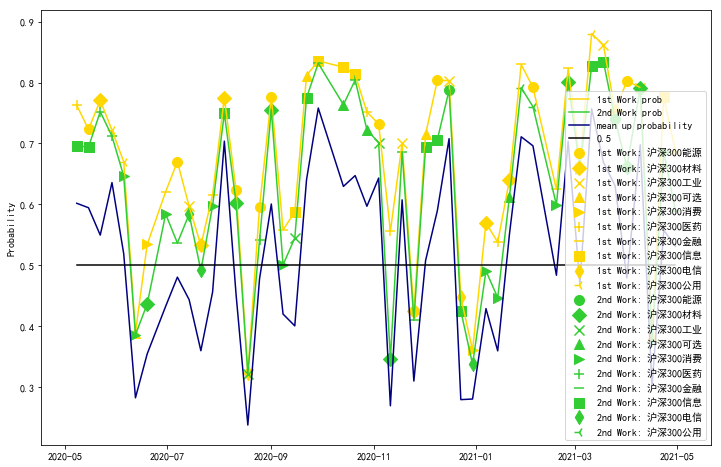

In [478]:
fig, axes = plt.subplots(1,figsize = (12,8))
axes.plot(df_Probability_Record.index,df_Probability_Record["1st Work prob"], label ="1st Work prob", color = "gold")
axes.plot(df_Probability_Record.index,df_Probability_Record["2nd Work prob"], label ="2nd Work prob", color = "limegreen") 
axes.plot(df_Probability_Record.index,df_Probability_Record["mean prob"], label = "mean up probability", color = "navy" )
axes.plot(df_Probability_Record.index,0.5 * np.ones(df_Probability_Record.shape[0]), label = "0.5", color = "k")
for work in work_area:
    x = df_Probability_Record.loc[df_Probability_Record["1st Work"] == work].index
    y = df_Probability_Record.loc[df_Probability_Record["1st Work"] == work]["1st Work prob"]
    axes.scatter(x,y, color = "gold", label = "1st Work: " + work, marker = dict_work_mark[work], s = 100)
for work in work_area:
    x = df_Probability_Record.loc[df_Probability_Record["2nd Work"] == work].index
    y = df_Probability_Record.loc[df_Probability_Record["2nd Work"] == work]["2nd Work prob"]
    axes.scatter(x,y, color = "limegreen", label = "2nd Work: " + work, marker = dict_work_mark[work], s = 100)
plt.ylabel("Probability")
plt.legend()

### Plot the detail about weight position in each trading date

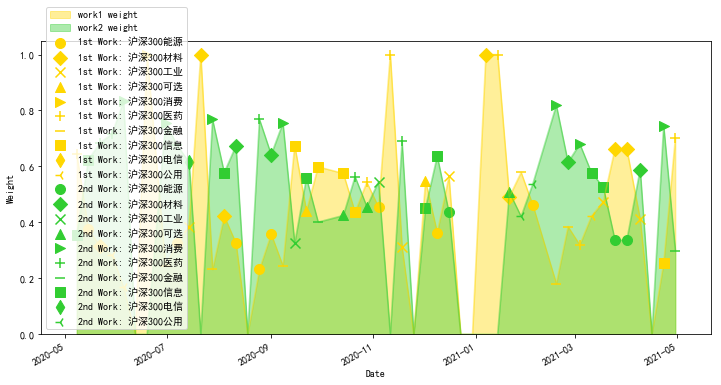

In [480]:
df_Position_detail[["work1 weight","work2 weight"]].plot.area(alpha = 0.4, color = ["gold","limegreen"], figsize = (12,6),stacked = False)
for work in work_area:
    x = df_Position_detail.loc[df_Position_detail["work1 Record"] == work].index
    y = df_Position_detail.loc[df_Position_detail["work1 Record"] == work]["work1 weight"]
    plt.scatter(x, y, color = "gold", label = "1st Work: " + work, marker = dict_work_mark[work], s = 100 )
for work in work_area:
    x = df_Position_detail.loc[df_Position_detail["work2 Record"] == work].index
    y = df_Position_detail.loc[df_Position_detail["work2 Record"] == work]["work2 weight"]
    plt.scatter(x, y, color = "limegreen", label = "2nd Work: " + work, marker = dict_work_mark[work], s = 100 )
plt.ylabel("Weight")
plt.legend()